### Importa Bibliotecas

In [1]:
# Bibliotecas básicas e manipulação de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem e análise de séries temporais
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Estatísticas e diagnósticos
from scipy.stats import kruskal, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
import statsmodels.api as sm

# Métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Salvar Modelos
import pickle

# Gerenciamento de avisos
import warnings
warnings.filterwarnings("ignore")  # Ignora avisos para manter o output limpo

### Funções

In [2]:
def testar_estacionariedade(serie):
    resultado = adfuller(serie)
    print('ADF Statistic:', resultado[0])
    print('p-value:', resultado[1])
    if resultado[1] < 0.05:
        print('A série é estacionária')
    else:
        print('A série não é estacionária')

### Tratamento Base

In [3]:
# 1. Carregar e preparar os dados
df = pd.read_parquet('base.parquet')

data_inicial = '20180101'
data_final = '20231201'

df = df[df['DATA_REFERENCIA'] >= data_inicial]
df = df[df['DATA_REFERENCIA'] <= data_final]

df.set_index('DATA_REFERENCIA', inplace=True)

# define target
#target = 'PD_LAG_1'
target = 'PD'

# Verificar as primeiras linhas
df.head()

,PD,IPCA_LAG_1,IPCA_LAG_3,IPCA_LAG_6,IPCA_LAG_12,DESEMPREGO_LAG_1,DESEMPREGO_LAG_3,DESEMPREGO_LAG_6,DESEMPREGO_LAG_12,PIB_LAG_1,...,PIB_LAG_6,PIB_LAG_12,SELIC_LAG_1,SELIC_LAG_3,SELIC_LAG_6,SELIC_LAG_12,CAMBIO_LAG_1,CAMBIO_LAG_3,CAMBIO_LAG_6,CAMBIO_LAG_12
DATA_REFERENCIA,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3.861777,5.410274,5.159236,2.918972,4.657135,11.9,12.3,12.9,12.7,588892.8,...,557458.2,526564.7,6.675963,7.956187,10.033869,13.893348,3.291915,3.191229,3.206138,3.196609
2018-02-01,3.798198,3.536617,3.412864,2.303129,4.032747,12.3,12.1,12.7,13.3,555644.6,...,555578.7,514120.5,7.186373,7.058561,10.033869,10.954329,3.210609,3.259380,3.150917,3.104194
2018-03-01,3.815173,3.908738,5.410274,1.935750,3.040525,12.7,11.9,12.5,13.9,528905.5,...,528871.2,544312.9,5.788102,6.675963,7.956187,13.353730,3.241500,3.291915,3.134790,3.127930
2018-04-01,3.823845,1.084909,3.536617,5.159236,1.692904,13.2,12.3,12.3,13.7,560120.7,...,549304.7,525238.1,6.548709,7.186373,7.956187,9.902948,3.279214,3.210609,3.191229,3.136172
2018-05-01,3.876315,2.671660,3.908738,3.412864,3.784558,13.0,12.7,12.1,13.4,559359.8,...,566209.3,548887.7,6.421594,5.788102,7.058561,11.748906,3.407495,3.241500,3.259380,3.209509


### Separação Treino/Teste

In [4]:
# Separar em treino e teste
train_size = int(len(df) * 0.8)  
df_train = df.iloc[:train_size]
df_train = df_train[target]
len(df_train)

57

In [5]:
test_size = len(df) - train_size
df_test = df.iloc[train_size:]
df_test = df_test[target]
len(df_test)

15

In [8]:
df_train.index.min()

Timestamp('2018-01-01 00:00:00')

In [9]:
df_train.index.max()

Timestamp('2022-09-01 00:00:00')

### A série é estacionária?

In [6]:
# Verificar a estacionariedade na variável alvo
testar_estacionariedade(df_train)

ADF Statistic: -2.9072347447415283
p-value: 0.04451314020969953
A série é estacionária


## Modelo ARIMA

### Testes de Autocorrelação

### PACF

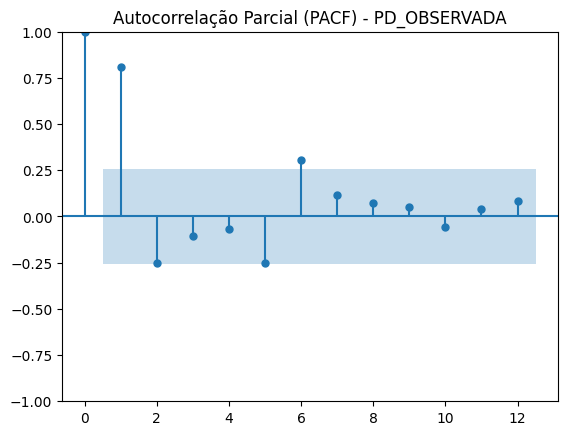

In [7]:
plot_pacf(df_train, lags=12)
plt.title('Autocorrelação Parcial (PACF) - PD_OBSERVADA')
plt.show()

### ACF

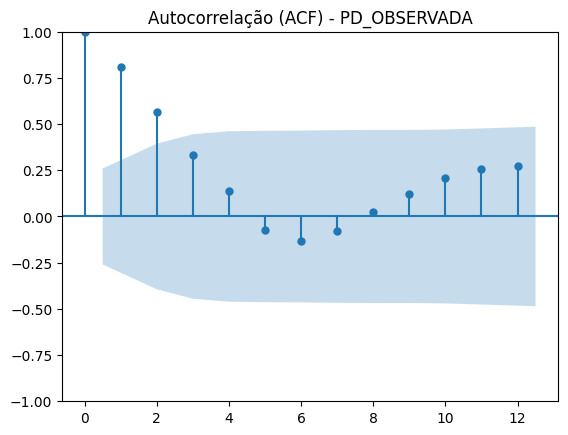

In [8]:
plot_acf(df_train.dropna(), lags=12)
plt.title('Autocorrelação (ACF) - PD_OBSERVADA')
plt.show()

### Decomposição Série

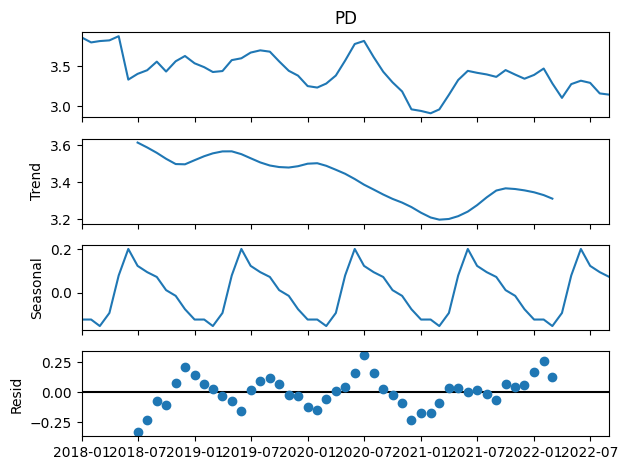

In [9]:
decomposition = seasonal_decompose(df_train, model='additive', period=12)
decomposition.plot()
plt.show()

### Parâmetros do ARIMA

In [10]:
# Parâmetros do modelo SARIMA
order = (1, 0, 2)  # ARIMA(p,d,q)
seasonal_order = (1, 0, 2, 12)  # Sazonal (P,D,Q,S)

In [11]:
# Lista para armazenar as previsões
predictions = []

### Treinamento do Modelo

In [12]:
# Rolling window - treinar o modelo iterativamente usando uma janela deslizante
for i in range(test_size):
    # Definir a janela de treino expandida (train + i)
    train_window = df.iloc[:train_size + i]

    # Ajustar o modelo SARIMAX na janela de treino
    model = SARIMAX(train_window[target], order=order, seasonal_order=seasonal_order)
    model_fit_arima = model.fit(disp=False)

    # Fazer previsão para o próximo ponto no tempo (usar .iloc[0] para acessar o valor previsto)
    pred = model_fit_arima.forecast(steps=1).iloc[0]
    predictions.append(pred)

In [13]:
# Imprima o resumo do modelo
print(model_fit_arima.summary()) 

                                     SARIMAX Results                                      
Dep. Variable:                                 PD   No. Observations:                   71
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                  51.803
Date:                            Sun, 17 Nov 2024   AIC                            -89.607
Time:                                    17:50:48   BIC                            -73.768
Sample:                                01-01-2018   HQIC                           -83.308
                                     - 11-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.006    169.269      0.000       0.988       1.011
ma.L1          0.1652      0.121   

### Análise dos Resíduos



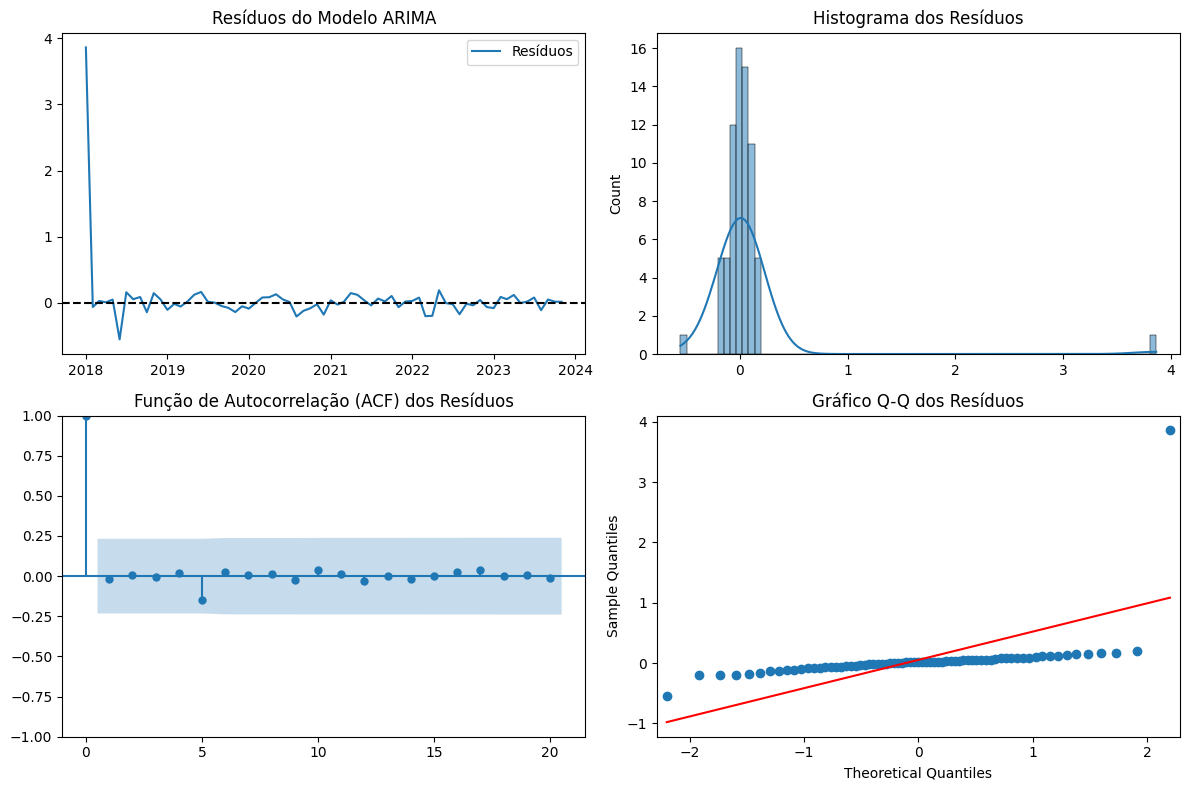


Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: 10758.5452
   - p-valor: 0.0000
   Os resíduos não seguem uma distribuição normal.

2. Teste de Ljung-Box (lag 10):
   - Estatística: 2.0023
   - p-valor: 0.9963
   Não há autocorrelação significativa nos resíduos.




In [14]:
# Pegando os resíduos do modelo ARIMA
residuos = model_fit_arima.resid

# Ajustando o erro no teste Jarque-Bera 
jb_stat, jb_pvalue = jarque_bera(residuos)

# Teste Ljung-Box
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

# Reexecutando o código para realizar os testes e gerar gráficos

# Criando os gráficos
plt.figure(figsize=(12, 8))

# Gráfico de resíduos
plt.subplot(2, 2, 1)
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo ARIMA')
plt.legend()

# Histograma dos resíduos
plt.subplot(2, 2, 2)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')

# ACF dos resíduos
plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(residuos, ax=plt.gca(), lags=20)
plt.title('Função de Autocorrelação (ACF) dos Resíduos')

# Q-Q plot
plt.subplot(2, 2, 4)
sm.qqplot(residuos, line='s', ax=plt.gca())
plt.title('Gráfico Q-Q dos Resíduos')

plt.tight_layout()
plt.show()

# Interpretando os resultados
interpretation = f"""
Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: {jb_stat:.4f}
   - p-valor: {jb_pvalue:.4f}
   {'Os resíduos seguem uma distribuição normal.' if jb_pvalue > 0.05 else 'Os resíduos não seguem uma distribuição normal.'}

2. Teste de Ljung-Box (lag 10):
   - Estatística: {ljung_box_test['lb_stat'].values[0]:.4f}
   - p-valor: {ljung_box_test['lb_pvalue'].values[0]:.4f}
   {'Não há autocorrelação significativa nos resíduos.' if ljung_box_test['lb_pvalue'].values[0] > 0.05 else 'Há autocorrelação significativa nos resíduos.'}

"""

print(interpretation)

### Gráfico dos Resíduos do Modelo ARIMA

A linha preta tracejada em zero representa a ausência de erro. Idealmente, os resíduos devem oscilar em torno dessa linha sem padrões visíveis. Nesse gráfico, os resíduos parecem estar centrados em torno de zero, o que é um bom sinal, mas há um grande pico no início que pode indicar a presença de um outlier ou ajuste imperfeito para esse ponto específico.

### Histograma dos Resíduos

A distribuição parece assimétrica, com uma concentração maior de resíduos próximos de zero, mas há valores em cauda direita que indicam outliers. A distribuição não parece seguir a forma de uma normal padrão, o que pode ser um problema dependendo da hipótese de normalidade.

### Função de Autocorrelação (ACF) dos Resíduos

A maioria dos pontos está dentro da faixa de confiança, indicando que os resíduos são quase independentes. O primeiro lag apresenta uma autocorrelação significativa, o que pode indicar alguma dependência temporal inicial que não foi capturada pelo modelo.

### Gráfico Q-Q (Quantil-Quantil)

A linha vermelha representa a distribuição normal teórica. Os pontos próximos ao centro seguem a linha, mas os pontos nas extremidades (caudas) desviam-se significativamente da linha, especialmente na cauda superior. Isso sugere que os resíduos não são perfeitamente normais, com a presença de outliers ou caudas pesadas.

### Vizualização Gráfica

### Vizualização Gráfica

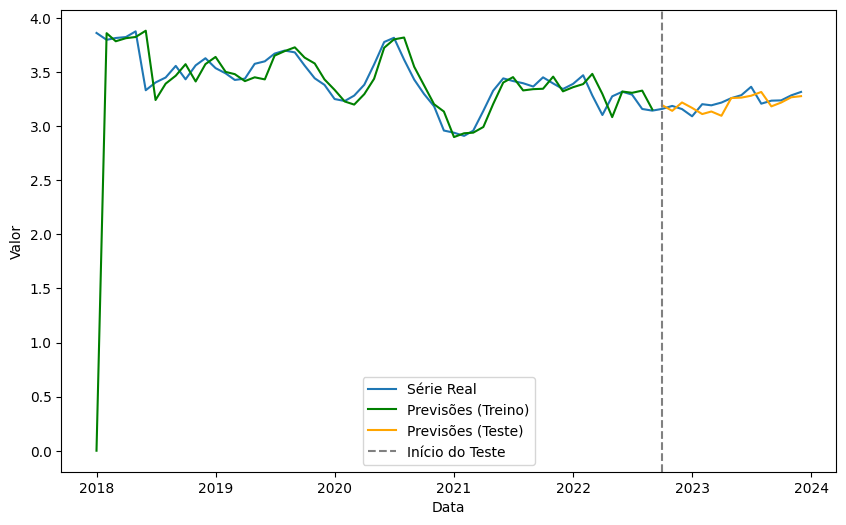

In [15]:
# Passo 2: Previsões para o período de treino
train_predictions = model_fit_arima.predict(start=df_train.index[0], end=df_train.index[-1])

# Passo 3: Previsões para o período de teste
test_predictions = model_fit_arima.predict(start=df_test.index[0], end=df_test.index[-1])

# Transformar as previsões em séries temporais com o mesmo índice dos dados originais
train_predictions_series = pd.Series(train_predictions, index=df_train.index, name='Previsões (Treino)')
test_predictions_series = pd.Series(test_predictions, index=df_test.index, name='Previsões (Teste)')

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target], label='Série Real')
plt.plot(train_predictions_series.index, train_predictions_series, label='Previsões (Treino)', color='green')
plt.plot(test_predictions_series.index, test_predictions_series, label='Previsões (Teste)', color='orange')
plt.axvline(x=df_test.index[0], color='gray', linestyle='--', label='Início do Teste')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()


### Métricas em Treino

In [16]:
# Alinhar as séries removendo o primeiro valor de fitted_values_aligned
fitted_values_aligned = train_predictions[1:]  # Remove o primeiro valor
actual_values = df_train.iloc[1:]  # Alinha com fitted_values_aligned

# Calcular métricas
rmse_arima_test = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_test = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_test = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_test}')
print(f'MAE: {mae_arima_test}')
print(f"MAPE: {mape_arima_test:.2f}%")


RMSE: 0.12172381846715302
MAE: 0.08640305403155543
MAPE: 2.56%


### Métricas em Teste

In [17]:
# Alinhar as séries removendo o primeiro valor de fitted_values_aligned
fitted_values_aligned = test_predictions[1:]  # Remove o primeiro valor
actual_values = df_test.iloc[1:]  # Alinha com fitted_values_aligned

# Calcular métricas
rmse_arima_test = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_test = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_test = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_test}')
print(f'MAE: {mae_arima_test}')
print(f"MAPE: {mape_arima_test:.2f}%")


RMSE: 0.06677845513357471
MAE: 0.05709778358043871
MAPE: 1.77%


# Autoarima

In [18]:
# Lista de valores de sazonalidade a serem testados
seasonalities = [3, 4, 6, 12]

# Variável para armazenar o melhor modelo
best_model_autoarima = None
best_aic = float('inf')

# Testar diferentes valores de sazonalidade
for m in seasonalities:
    print(f"Testando sazonalidade m={m}")
    model = auto_arima(
        df_train, 
        seasonal=True,  # Para considerar sazonalidade
        m=m,            # Testa um valor específico de sazonalidade
        trace=True, 
        suppress_warnings=True, 
        error_action='ignore', 
        stepwise=True
    )
    
    # Verifica se o modelo atual é melhor que o anterior
    if model.aic() < best_aic:
        best_model_autoarima = model
        best_aic = model.aic()

Testando sazonalidade m=3
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=-67.588, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=-66.933, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=-68.691, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=-69.026, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[3] intercept   : AIC=-66.557, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[3] intercept   : AIC=-68.452, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[3] intercept   : AIC=-69.511, Time=0.10 sec
 ARIMA(0,1,0)(2,0,1)[3] intercept   : AIC=-74.837, Time=0.10 sec
 ARIMA(0,1,0)(2,0,0)[3] intercept   : AIC=-76.792, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[3] intercept   : AIC=-74.876, Time=0.09 sec
 ARIMA(0,1,1)(2,0,0)[3] intercept   : AIC=-74.894, Time=0.09 sec
 ARIMA(1,1,1)(2,0,0)[3] intercept   : AIC=-72.981, Time=0.17 sec
 ARIMA(0,1,0)(2,0,0)[3]             : AIC=-77.627, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[3]  

In [19]:
# Imprima o resumo do modelo
print(best_model_autoarima.summary()) 

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 3)   Log Likelihood                  41.813
Date:                           Sun, 17 Nov 2024   AIC                            -77.627
Time:                                   17:51:14   BIC                            -71.551
Sample:                               01-01-2018   HQIC                           -75.271
                                    - 09-01-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L3       -0.1725      0.182     -0.947      0.344      -0.530       0.185
ar.S.L6       -0.5177      0.083     -6.258

### Análise dos Resíduos



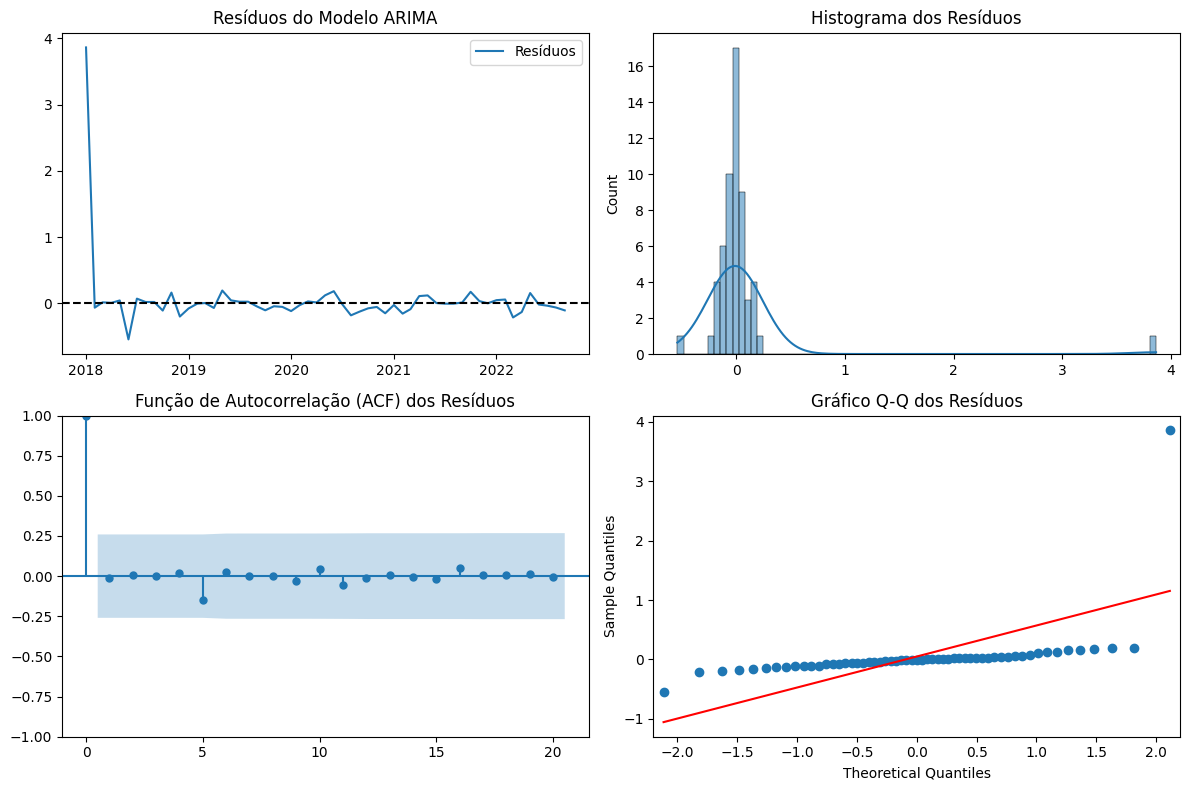


Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: 5623.1785
   - p-valor: 0.0000
   Os resíduos não seguem uma distribuição normal.

2. Teste de Ljung-Box (lag 10):
   - Estatística: 1.6750
   - p-valor: 0.9983
   Não há autocorrelação significativa nos resíduos.




In [20]:
# Pegando os resíduos do modelo ARIMA
residuos = best_model_autoarima.resid()  # Chamar o método resid()

# Ajustando o erro no teste Jarque-Bera 
jb_stat, jb_pvalue = jarque_bera(residuos)

# Teste Ljung-Box
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

# Criando os gráficos
plt.figure(figsize=(12, 8))

# Gráfico de resíduos
plt.subplot(2, 2, 1)
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo ARIMA')
plt.legend()

# Histograma dos resíduos
plt.subplot(2, 2, 2)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')

# ACF dos resíduos
plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(residuos, ax=plt.gca(), lags=20)
plt.title('Função de Autocorrelação (ACF) dos Resíduos')

# Q-Q plot
plt.subplot(2, 2, 4)
sm.qqplot(residuos, line='s', ax=plt.gca())
plt.title('Gráfico Q-Q dos Resíduos')

plt.tight_layout()
plt.show()

# Interpretando os resultados
interpretation = f"""
Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: {jb_stat:.4f}
   - p-valor: {jb_pvalue:.4f}
   {'Os resíduos seguem uma distribuição normal.' if jb_pvalue > 0.05 else 'Os resíduos não seguem uma distribuição normal.'}

2. Teste de Ljung-Box (lag 10):
   - Estatística: {ljung_box_test['lb_stat'].values[0]:.4f}
   - p-valor: {ljung_box_test['lb_pvalue'].values[0]:.4f}
   {'Não há autocorrelação significativa nos resíduos.' if ljung_box_test['lb_pvalue'].values[0] > 0.05 else 'Há autocorrelação significativa nos resíduos.'}

"""

print(interpretation)

### Vizualização Gráfica

In [21]:
# Passo 1: Reajuste o melhor modelo no conjunto completo de treino (df_train)
best_model_autoarima.fit(df_train)

# Passo 2: Previsões para o período de treino
train_predictions = best_model_autoarima.predict_in_sample()

# Passo 3: Previsões para o período de teste
test_predictions = best_model_autoarima.predict(n_periods=len(df_test))

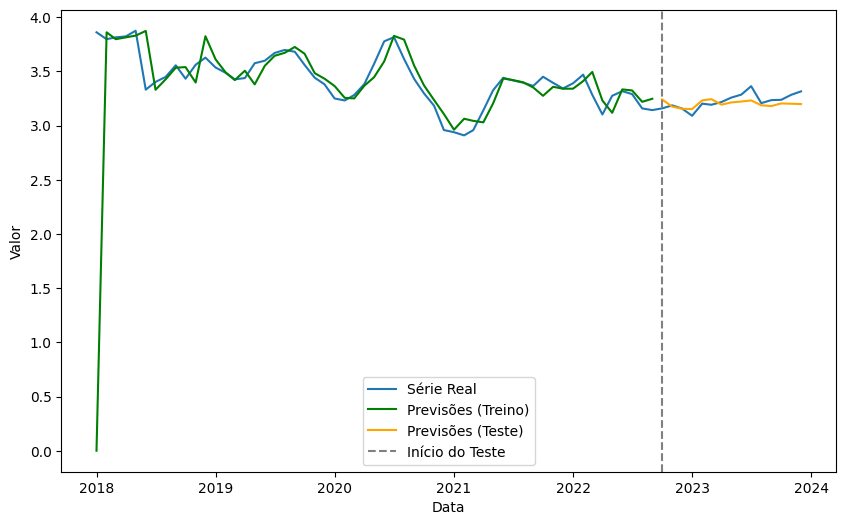

In [22]:
# Transformar as previsões em séries temporais com o mesmo índice dos dados originais
train_predictions_series = pd.Series(train_predictions, index=df_train.index, name='Previsões (Treino)')
test_predictions_series = pd.Series(test_predictions, index=df_test.index, name='Previsões (Teste)')

# Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[target], label='Série Real')
plt.plot(train_predictions_series.index, train_predictions_series, label='Previsões (Treino)', color='green')
plt.plot(test_predictions_series.index, test_predictions_series, label='Previsões (Teste)', color='orange')
plt.axvline(x=df_test.index[0], color='gray', linestyle='--', label='Início do Teste')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

### Métricas em Treino

In [23]:
# Alinhar as séries removendo o primeiro valor de fitted_values_aligned
fitted_values_aligned = train_predictions[1:].values
actual_values = df_train.iloc[1:].values

# Calcular métricas
rmse_arima_test = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_test = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_test = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_test}')
print(f'MAE: {mae_arima_test}')
print(f"MAPE: {mape_arima_test:.2f}%")


RMSE: 0.11905403526316677
MAE: 0.08195842037853038
MAPE: 2.43%


### Métricas em Teste

In [24]:
# Alinhar as séries removendo o primeiro valor de fitted_values_aligned
fitted_values_aligned = test_predictions[1:].values
actual_values = df_test.iloc[1:].values

# Calcular métricas
rmse_arima_test = np.sqrt(mean_squared_error(actual_values, fitted_values_aligned))
mae_arima_test = mean_absolute_error(actual_values, fitted_values_aligned)
mape_arima_test = np.mean(np.abs((actual_values - fitted_values_aligned) / actual_values)) * 100

print(f'RMSE: {rmse_arima_test}')
print(f'MAE: {mae_arima_test}')
print(f"MAPE: {mape_arima_test:.2f}%")


RMSE: 0.06351685361787071
MAE: 0.05202948023425386
MAPE: 1.59%


In [25]:
modelo_escolhido = best_model_autoarima
modelo_escolhido

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 0, 0, 3),
      suppress_warnings=True, with_intercept=False)

In [26]:
# Nome do arquivo onde o modelo será salvo
model_filename = 'modelo_sarima.pkl'

# Salvando o modelo em um arquivo pickle
with open(model_filename, 'wb') as file:
    pickle.dump(modelo_escolhido, file)

print(f"Modelo salvo em: {model_filename}")

Modelo salvo em: modelo_sarima.pkl
